In [2]:
import torch
import triton
import triton.language as tl
from entmax import entmax_bisect


### Goal: Implement entmax bisection in Triton

Entmax mapping is given by:
$$
\alpha\text{-entmax}_i(x_i) = [(\alpha - 1)x_i - \tau]_+^{\frac{1}{\alpha-1}} 
$$

Thus, for one to calculate entmax, one requires to find $\tau$ that satistfies $\sum_i [(\alpha - 1)x_i - \tau]_+^{\frac{1}{\alpha-1}} = 1$, that is, that satisfies that the sum of all entries sums to one.

Thus let the define the function f($\tau$) for which we are trying to find the root for:
$$
f(\tau) = \sum_i [(\alpha - 1)x_i - \tau]_+^{\frac{1}{\alpha-1}} - 1
$$

Currently, in the entmax package (pip install entmax) the algorithm to calculate this $\tau$ makes use of the bisection algorithm. Thus, a high-level description of the algorithm goes like this:

$$
\begin{align*}
\text{Input: }& x \in \mathbb{R}^n, \alpha \in \mathbb{R}, T \text{ iterations} \\
\text{(1): }& \max \leftarrow \max(x) \\ 
\text{(2): }& \text{Initialize } \tau_\text{lo} = \max - 1,\tau_\text{hi} = \max - n^{1-\alpha}, \tau = \frac{\tau_\text{lo} + \tau_\text{hi}}{2} \\
\text{(3): }& \text{For t in T iteraions do:} \\
&\quad\text{Compute } f(\tau) \\
&\quad\text{If } f(\tau) > 0: \tau_\text{lo} = \tau \text{ else } \tau_\text{hi} = \tau \\
&\quad\tau \leftarrow \frac{\tau_\text{lo} + \tau_\text{hi}}{2} \\
\text{(4): }& \text{Store element-wise }  [(\alpha - 1)x_i - \tau]_+^{\frac{1}{\alpha-1}} \\
\end{align*}
$$

## Step 1: Compute maximum.

In [ ]:
@triton.jit
def _ent_bisect(x_ptr, y_ptr, alpha, n_iter, N: tl.constexpr, TILE: tl.constexpr):
    
    # same as torch.arange
    offsets = tl.arange(0, TILE)

    # placeholder for max value
    max_val = -1.0e3

    for idx in range(0, N, TILE):
        # compute pointers for the current tile
        x_ptrs = (x_ptr + idx) + offsets

        # load TILE elements of X
        x = tl.load(x_ptrs)

        # update max value
        max_val = tl.maximum(max_val, tl.max(x))

    max_val *= (alpha - 1.0)


def run_entmax_triton(x, y, alpha=1.5, n_iter=50):
    TILE = 1024
    _ent_bisect[(1,)](x, y, alpha, n_iter, x.size(0), TILE)

## Step 2: Compute $\tau$ using bisection.

In [ ]:
@triton.jit
def alpha_entmax(x, tau, alpha):
    x = (alpha - 1) * x - tau
    x = tl.where(x > 0, tl.exp2(1 / (alpha - 1) * tl.log2(x)), 0.0)
    return x


@triton.jit
def _ent_bisect(x_ptr, y_ptr, alpha, n_iter, N: tl.constexpr, TILE: tl.constexpr):
    
    # same as torch.arange
    offsets = tl.arange(0, TILE)

    # placeholder for max value
    max_val = -1.0e3

    for idx in range(0, N, TILE):
        # compute pointers for the current tile
        x_ptrs = (x_ptr + idx) + offsets

        # load TILE elements of X
        x = tl.load(x_ptrs)

        # update max value
        max_val = tl.maximum(max_val, tl.max(x))

    max_val *= (alpha - 1.0)

    # initialize tau bounds
    tau_lower = max_val - 1.0
    tau_upper = max_val - tl.exp2((1-alpha) * tl.log2(1.0*N))
    tau = (tau_lower + tau_upper) / 2.0
    
    # bisection
    for _ in range(n_iter):
        f_tau = -1.0

        for idx in range(0, N, TILE):
            # compute pointers for the current tile
            x_ptrs = (x_ptr + idx) + offsets

            # load TILE elements of X
            x = tl.load(x_ptrs)

            # accumulate f(tau)
            f_tau += tl.sum(alpha_entmax(x, tau, alpha))

        # update tau bounds
        if f_tau > 0:
            tau_lower = tau
        else:
            tau_upper = tau
        tau = (tau_lower + tau_upper) / 2.0


def run_entmax_triton(x, y, alpha=1.5, n_iter=50):
    TILE = 1024
    _ent_bisect[(1,)](x, y, alpha, n_iter, x.size(0), TILE)

# Step 3: Store the result.

In [24]:
@triton.jit
def alpha_entmax(x, tau, alpha):
    x = (alpha - 1) * x - tau
    x = tl.where(x > 0, tl.exp2(1 / (alpha - 1) * tl.log2(x)), 0.0)
    return x


@triton.jit
def _ent_bisect(x_ptr, y_ptr, alpha, n_iter, N: tl.constexpr, TILE: tl.constexpr):
    
    # same as torch.arange
    offsets = tl.arange(0, TILE)

    # placeholder for max value
    max_val = -1.0e3

    for idx in range(0, N, TILE):
        # compute pointers for the current tile
        x_ptrs = (x_ptr + idx) + offsets

        # load TILE elements of X
        x = tl.load(x_ptrs)

        # update max value
        max_val = tl.maximum(max_val, tl.max(x))

    max_val *= (alpha - 1.0)

    # initialize tau bounds
    tau_lower = max_val - 1.0
    tau_upper = max_val - tl.exp2((1-alpha) * tl.log2(1.0*N))
    tau = (tau_lower + tau_upper) / 2.0
    
    # bisection
    for _ in range(n_iter):
        f_tau = -1.0

        for idx in range(0, N, TILE):
            # compute pointers for the current tile
            x_ptrs = (x_ptr + idx) + offsets

            # load TILE elements of X
            x = tl.load(x_ptrs)

            # accumulate f(tau)
            f_tau += tl.sum(alpha_entmax(x, tau, alpha))

        # update tau bounds
        if f_tau > 0:
            tau_lower = tau
        else:
            tau_upper = tau
        tau = (tau_lower + tau_upper) / 2.0


    for idx in range(0, N, TILE):
            # compute pointers for the current tile
            x_ptrs = (x_ptr + idx) + offsets
            y_ptrs = (y_ptr + idx) + offsets

            # load TILE elements of X
            x = tl.load(x_ptrs)

            # compute entmax for this TILE
            y = alpha_entmax(x, tau, alpha)

            # store results
            tl.store(y_ptrs, y)

def run_entmax_triton(x, y, alpha=1.5, n_iter=50):
    TILE = 1024
    _ent_bisect[(1,)](x, y, alpha, n_iter, x.size(0), TILE)

In [25]:
alpha = 1.2
n_iter = 50

x = torch.randn(2048, device='cuda', dtype=torch.float32)
y = torch.empty_like(x, device='cuda', dtype=torch.float32)

In [26]:
entmax_bisect(x, alpha=alpha, n_iter=n_iter, dim=0)

tensor([0.0000, 0.0000, 0.0001,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [28]:
(y - entmax_bisect(x, alpha=alpha, n_iter=n_iter, dim=0)).abs().max()

tensor(2.2352e-08, device='cuda:0')

In [ ]:
y.sum()

(tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))

In [60]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'], 
        x_vals=[4096, 8192, 16384],
        line_arg='provider', 
        line_vals=['triton', 'torch'],  
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '--')], 
        ylabel='Time (ms)', 
        plot_name='entmax-perf',
        args={},
    ))



def benchmark(size, provider):
    alpha = 1.5
    n_iter = 20
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    y = torch.empty(size, device="cuda", dtype=torch.float32)

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: entmax_bisect(x, n_iter=n_iter, dim=0), quantiles=quantiles, warmup=500, rep=1000)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: run_entmax_triton(x, y, alpha=alpha, n_iter=n_iter), quantiles=quantiles, warmup=500, rep=1000)
    return ms

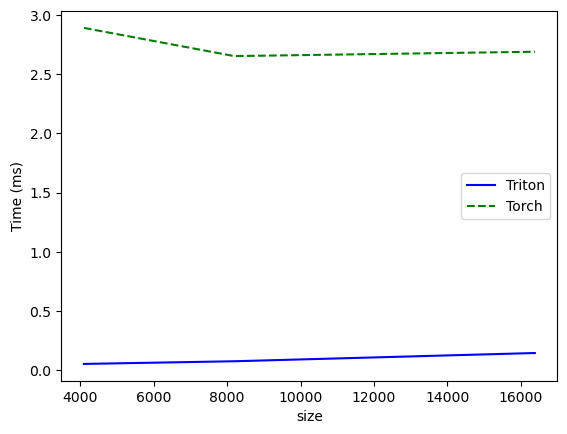

entmax-perf:
      size    Triton     Torch
0   4096.0  0.051200  2.891264
1   8192.0  0.073728  2.653184
2  16384.0  0.143360  2.690048


In [61]:
benchmark.run(print_data=True, show_plots=True)

In [69]:
@triton.jit
def alpha_entmax(x, tau, alpha):
    x = (alpha - 1) * x - tau
    x = tl.where(x > 0, tl.exp2(1 / (alpha - 1) * tl.log2(x)), 0.0)
    return x


@triton.jit
def _ent_bisect(x_ptr, y_ptr, alpha, n_iter, N: tl.constexpr, TILE: tl.constexpr):
    # get row that this thread block will be responsible for
    curr_row = tl.program_id(0)

    # move pointers to the start of the input and output tensors
    x_ptr += curr_row * N
    y_ptr += curr_row * N
    
    # same as torch.arange
    offsets = tl.arange(0, TILE)

    # placeholder for max value
    max_val = -1.0e3

    for idx in range(0, N, TILE):
        # compute pointers for the current tile
        x_ptrs = (x_ptr + idx) + offsets

        # load TILE elements of X
        x = tl.load(x_ptrs)

        # update max value
        max_val = tl.maximum(max_val, tl.max(x))

    max_val *= (alpha - 1.0)

    # initialize tau bounds
    tau_lower = max_val - 1.0
    tau_upper = max_val - tl.exp2((1-alpha) * tl.log2(1.0*N))
    tau = (tau_lower + tau_upper) / 2.0
    
    # bisection
    for _ in range(n_iter):
        f_tau = -1.0

        for idx in range(0, N, TILE):
            # compute pointers for the current tile
            x_ptrs = (x_ptr + idx) + offsets

            # load TILE elements of X
            x = tl.load(x_ptrs)

            # accumulate f(tau)
            f_tau += tl.sum(alpha_entmax(x, tau, alpha))

        # update tau bounds
        if f_tau > 0:
            tau_lower = tau
        else:
            tau_upper = tau
        tau = (tau_lower + tau_upper) / 2.0


    for idx in range(0, N, TILE):
            # compute pointers for the current tile
            x_ptrs = (x_ptr + idx) + offsets
            y_ptrs = (y_ptr + idx) + offsets

            # load TILE elements of X
            x = tl.load(x_ptrs)

            # compute entmax for this TILE
            y = alpha_entmax(x, tau, alpha)

            # store results
            tl.store(y_ptrs, y)

def run_entmax_triton(x, y, alpha=1.5, n_iter=50):
    TILE = 1024
    # launch with as many blocks as rows in x
    rows, cols = x.shape
    grid = (rows,)
    _ent_bisect[grid](x, y, alpha, n_iter, cols, TILE)

In [70]:
alpha = 1.5
n_iter = 50

x = torch.randn((16, 2048), device='cuda', dtype=torch.float32).contiguous()
y = torch.empty_like(x, device='cuda', dtype=torch.float32).contiguous()

In [71]:
run_entmax_triton(x, y, alpha=alpha, n_iter=n_iter)

In [73]:
(y - entmax_bisect(x, alpha=alpha, n_iter=n_iter, dim=1)).abs().max()

tensor(1.7881e-07, device='cuda:0')

In [74]:
y.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [75]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'], 
        x_vals=[4096, 8192, 16384],
        line_arg='provider', 
        line_vals=['triton', 'torch'],  
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '--')], 
        ylabel='Time (ms)', 
        plot_name='entmax-perf',
        args={},
    ))



def benchmark(size, provider):
    alpha = 1.5
    n_iter = 20
    x = torch.rand((256,size), device="cuda", dtype=torch.float32)
    y = torch.empty((256,size), device="cuda", dtype=torch.float32)

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: entmax_bisect(x, n_iter=n_iter, dim=0), quantiles=quantiles, warmup=500, rep=1000)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: run_entmax_triton(x, y, alpha=alpha, n_iter=n_iter), quantiles=quantiles, warmup=500, rep=1000)
    return ms

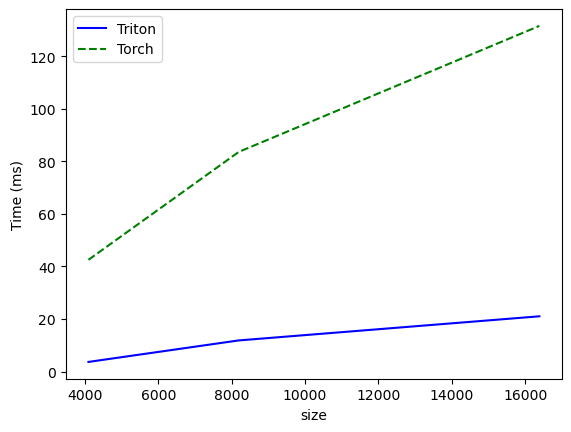

entmax-perf:
      size     Triton       Torch
0   4096.0   3.670016   42.532352
1   8192.0  11.853824   83.594242
2  16384.0  21.031937  131.547653


In [76]:
benchmark.run(print_data=True, show_plots=True)

In [ ]:
# entmax-perf:
#       size     Triton       Torch
# 0   4096.0   3.670016   42.532352
# 1   8192.0  11.853824   83.594242
# 2  16384.0  21.031937  131.547653